#Libraries

In [ ]:
import gym
from gym import wrappers
from gym import spaces
from google.colab import widgets

import timeit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

#Grid World Env

In [ ]:

class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16) #Intializing a 4x4 grid with 16 states: {s1, s2, s3,....s16}
        self.action_space = spaces.Discrete(4) #Intializing 4 actions:  {0: down, 1: up, 2: right, 3: left}
        self.done = False
        #rewards = {-2, -1, 0, 1, 2, 150} defined below
        
    def reset(self):
  
        self.agent_pos = [0, 0] #start position
        self.goal_pos = [3, 3] #target position (+150)
        self.danger1_pos = [1,1] #first danger position (-1)
        self.danger2_pos = [2,2] #second danger position (-2)
        self.gold1_pos = [2,0] #First positive reward position (+1)
        self.gold2_pos = [3,0] #Second positive reward position (+2)
        self.done = False
        self.state = np.zeros((4,4))
        observation = self.state.flatten()
        return observation
    
    def step(self, action, deterministic = False, stochastic = False):

        #determinstic environment
        if deterministic == True:
          epsilon1, epsilon2 = 1, 1 #With probability 1 Agent chooses given action

        #stochastic environment
        if stochastic == True:
          epsilon1, epsilon2 = 0.7, 0.8 #Transistion probabilites of 0.7 and 0.8 
          #Σ(p(s', r/s, down) = 0.7 + 0.3 = 1
          #Σ(p(s', r/s, right) = 0.8 + 0.2 = 1 

        #Actions
        if action == 0: #down
            rand_num1 = np.random.random()
            if epsilon1 >= rand_num1:  
              self.agent_pos[0] += 1   
            else: #For all states in stochastic environment when Down action is choosen: Agent chooses down state with a transition probability of 0.7 and up state with 0.3 transition probaility
              self.agent_pos[0] -= 1
              # print("Up state is choosen with 0.3 probability instead of Down")

        if action == 1: #up
            self.agent_pos[0] -= 1

        if action == 2: #right
            rand_num2 = np.random.random()
            if epsilon2 >= rand_num2:  
              self.agent_pos[1] += 1        
            else:#For all states in stochastic environment when Right action is choosen: Agent chooses right state with a transition probability of 0.8 and left state with 0.2 transition probaility
              self.agent_pos[1] -= 1
              # print("Left state is choosen with 0.2 probability instead of Right")

        if action == 3: #left
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3) #ensuring agent doesn't go out of the grid #One of the ways to ensure safety in the environment
        self.state = np.zeros((4,4))

        observation = self.state.flatten()
        
        reward = 0 #Intializing reward to zero

        #Rewards structure
        if (self.agent_pos == self.goal_pos).all():
            reward = 150 #A reward of 150 if it reaches target position
            self.done = True

        elif (self.agent_pos == self.danger1_pos).all():
            reward = -1 #A negative reward -1 if it enters 1st danger position

        elif (self.agent_pos == self.danger2_pos).all():
            reward = -2 #A negative reward of -2 if it enters 2nd danger position

        elif (self.agent_pos == self.gold1_pos).all():
            reward = 1 #A reward of +1 at [2,0]

        elif (self.agent_pos == self.gold2_pos).all():
            reward = 2 #A reward of +2 at [3,0]

        return self.agent_pos, reward, self.done
        
    def render(self):
        plt.imshow(self.state)

In [ ]:
env = GridEnvironment()
obs = env.reset()#resets the environment to its initial configuration

#Displays grid in its intial configuration
print("Grid Environment\n")
output_grid2 = widgets.Grid(4, 4, header_row=True, header_column=True,  style='background-color: black; font-size: 25px; color: white')
print("\n")
with output_grid2.output_to(0, 0):
    print("Start")
with output_grid2.output_to(3, 3):
    print("Target")
with output_grid2.output_to(1, 1):
    print("-1")
with output_grid2.output_to(2, 2):
    print("-2")
with output_grid2.output_to(2, 0):
    print("+1")
with output_grid2.output_to(3, 0):
    print("+2")

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+2


<IPython.core.display.Javascript object>

#Part I

##Actor-Critic (TD) on Grid world

In [ ]:
#Agent declaration
class Actor_Critic_Agent():
    def __init__(self, alpha, beta, gamma=0.99, n_actions=4):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_actions = n_actions

        self.actor_model, self.critic_model, self.policy_model = self.actor_critic_model()
        self.action_space = [i for i in range(n_actions)]

    def actor_critic_model(self):
        input = Input(shape=(16,))
        TD_error = Input(shape=[1])
        hidden_d1 = Dense(1024, activation='relu')(input)
        hidden_d2 = Dense(512, activation='relu')(hidden_d1)
        values = Dense(1, activation='linear')(hidden_d2) #for critic model
        probs = Dense(self.n_actions, activation='softmax')(hidden_d2) #output of a actor model, policy model

        def actor_loss(y_t, y_p):
            return K.sum(- y_t * K.log(K.clip(y_p, 1E-8, 1-1E-8)) * TD_error)

        # Defining an Actor model
        actor_model = Model([input, TD_error], [probs])
        actor_optimizer = Adam(lr=self.alpha)
        actor_model.compile(optimizer=actor_optimizer, loss=actor_loss)

        # Defining a critic model
        critic_model = Model([input], [values])
        critic_optimizer = Adam(lr=self.beta)        
        critic_model.compile(optimizer= critic_optimizer, loss='mse')

        # Defining an additional policy network
        policy_model = Model([input], [probs])

        return actor_model, critic_model, policy_model

    def pick_action(self, state, evaluation = False):
        state = np.expand_dims(state, axis=0)
        probabilities = self.policy_model.predict(state)[0]
        if evaluation == False:
            action = np.random.choice(self.action_space, p=probabilities)
        else:
            action = np.argmax(probabilities)
        return action

    def train(self, state, action, reward, next_state, done):
        # use expand dims to add a dimension to a numpy arra
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        # get the target values
        next_critic_value = self.critic_model.predict(next_state)
        critic_value = self.critic_model.predict(state)

        # Getting TD error values to feed into the actor model
        target = reward + self.gamma*next_critic_value*(1-int(done))
        TD_error =  target - critic_value

        actions = np.zeros((1, self.n_actions))
        actions[[0], action] = 1

        #fitting actor and critic models
        self.actor_model.fit([state, TD_error], actions, verbose=0)
        self.critic_model.fit(state, target, verbose=0)

Episode: 1, Average rewards: 0
Episode: 500, Average rewards: 268.5
Episode: 1000, Average rewards: 267.8
Episode: 1500, Average rewards: 268.9
Episode: 2000, Average rewards: 269.4
Episode: 2500, Average rewards: 269.8
Episode: 3000, Average rewards: 270.0
Episode: 3500, Average rewards: 271.6
Episode: 4000, Average rewards: 272.6
Episode: 4500, Average rewards: 271.4
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 16 -> Episode: 5000, Average rewards: 273.0


Text(0.5, 1.0, 'Evaluation: Rewards per episode')

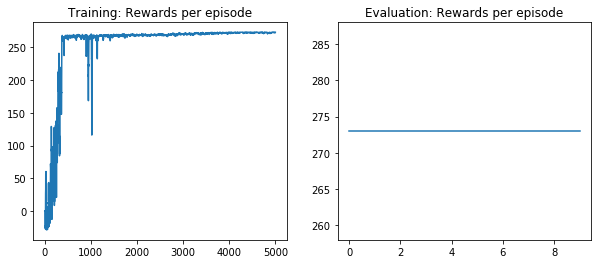

In [ ]:
#TD Actor critic on grid world
states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

#Agent and environment intialization
agent = Actor_Critic_Agent(alpha=0.00001, beta=0.00005)
env = GridEnvironment()

#episodes
total_episodes = 5000
eval_episodes = total_episodes - 10

#lists to store rewards
reward_values = []
rewards = []
eva_rewards = []
avg_rewards = 0

#final path
optimal = [1]
target = np.array([3,3])


#Looping over the episodes
for episode in range(1, total_episodes+1):
    
    done = False
    current = np.array([0,0])
    total_rewards = 0
    timesteps = 0
    state = env.reset()
    
    while timesteps < 10 and not done:
        
        if episode >= eval_episodes:
            action = agent.pick_action(state, evaluation = True)
        else:
            action = agent.pick_action(state)
            
        next_state_pos, reward, done = env.step(action, deterministic=True)
        next_state = states[tuple(next_state_pos)]
        
        
        #for evaluation results
        if episode == total_episodes - 1:
          optimal.append(next_state + 1)

         
        #Running rewards
        if reward == 150: #if agent reaches goal
          reward += 100
        
        if np.linalg.norm(current - np.array(next_state_pos)) < 0.5: #if agent stays in same position
          reward = reward - 10  
        current = np.array(next_state_pos)
        
        if np.linalg.norm(target - np.array(next_state_pos)) <= 1: #if agent is in vicinity of goal position
          reward = reward + 10 
        
        #Training
        next_state = to_categorical(next_state, 16)
        agent.train(state, action, reward, next_state, done)
        state = next_state 
        total_rewards += reward
        timesteps += 1

    #Each episode
    rewards.append(total_rewards)
    
    if episode >= 10:
      avg_rewards = np.sum(rewards[episode-10:]) / 10
    
    reward_values.append(avg_rewards)

    if episode % (total_episodes // 10) == 0 or episode == 1:
      print("Episode: {}, Average rewards: {}".format(episode, avg_rewards))
    
    #Evaluation
    if episode > eval_episodes:
      eva_rewards.append(total_rewards)
    
    #printing optimal path in last episode
    if episode == total_episodes - 1:
          print("Optimal Path: ")
          for i in optimal:
            print(i,"->", end = " ")
          

#plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
x = [episode for episode in range(total_episodes)]
x_eva = [episode for episode in range(10)]
yr = reward_values
ye = eva_rewards
  
ax1.plot(x,yr)
ax1.set_title("Training: Rewards per episode")

ax2.plot(x_eva,ye)
ax2.set_title("Evaluation: Rewards per episode")

#Part II

##1. Lunar Lander-v2

In [ ]:
# !pip3 install Box2D
# !pip3 install box2d-py
# !pip3 install gym[all]
# !pip3 install gym[Box_2D]
# !sudo apt-get install swig

In [ ]:
#Agent declaration
class AC_Lunarlander_Agent():
    def __init__(self, alpha, beta, gamma=0.99, n_actions=4):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_actions = n_actions

        self.actor_model, self.critic_model, self.policy_model = self.actor_critic_model()
        self.action_space = [i for i in range(n_actions)]

    def actor_critic_model(self):
        input = Input(shape=(8,))
        TD_error = Input(shape=[1])
        hidden_d1 = Dense(1024, activation='relu')(input)
        hidden_d2 = Dense(512, activation='relu')(hidden_d1)
        values = Dense(1, activation='linear')(hidden_d2) #for critic model
        probs = Dense(self.n_actions, activation='softmax')(hidden_d2) #output of a actor model, policy model

        def actor_loss(y_t, y_p):
            return K.sum(- y_t * K.log(K.clip(y_p, 1E-8, 1-1E-8)) * TD_error)

        # Defining an Actor model
        actor_model = Model([input, TD_error], [probs])
        actor_optimizer = Adam(lr=self.alpha)
        actor_model.compile(optimizer=actor_optimizer, loss=actor_loss)

        # Defining a critic model
        critic_model = Model([input], [values])
        critic_optimizer = Adam(lr=self.beta)        
        critic_model.compile(optimizer= critic_optimizer, loss='mse')

        # Defining an additional policy network
        policy_model = Model([input], [probs])

        return actor_model, critic_model, policy_model

    def pick_action(self, state, evaluation = False):
        state = np.expand_dims(state, axis=0)
        probabilities = self.policy_model.predict(state)[0]
        if evaluation == False:
            action = np.random.choice(self.action_space, p=probabilities)
        else:
            action = np.argmax(probabilities)
        return action

    def train(self, state, action, reward, next_state, done):
        # use expand dims to add a dimension to a numpy array
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        # get the target values
        next_critic_value = self.critic_model.predict(next_state)
        critic_value = self.critic_model.predict(state)

        # Getting TD error values to feed into the actor model
        target = reward + self.gamma*next_critic_value*(1-int(done))
        TD_error =  target - critic_value

        actions = np.zeros((1, self.n_actions))
        actions[[0], action] = 1

        #fitting actor and critic models
        self.actor_model.fit([state, TD_error], actions, verbose=0)
        self.critic_model.fit(state, target, verbose=0)

Episode: 1, Average rewards: 0
Episode: 300, Average rewards: -147.0224669967707
Episode: 600, Average rewards: -8.82519287219878
Episode: 900, Average rewards: 109.5335588857217
Episode: 1200, Average rewards: 138.4921233030568


Text(0.5, 1.0, 'Evaluation: Rewards per episode')

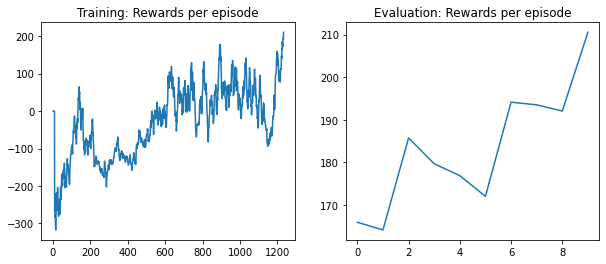

In [ ]:
#TD actor-critic on LunarLander-v2
agent = AC_Lunarlander_Agent(alpha=0.00001, beta=0.00005)
env = gym.make('LunarLander-v2')


#episodes
total_episodes = 3000
eval_episodes = total_episodes - 10

#lists to store rewards
reward_values = []
rewards = []
eva_rewards = []
avg_rewards = 0


for episode in range(1, total_episodes+1):
    
    done = False
    total_rewards = 0
    state = env.reset()
    
    while not done:
        
        if episode >= eval_episodes:
            action = agent.pick_action(state, evaluation = True)
        else:
            action = agent.pick_action(state)
   
        next_state, reward, done, info = env.step(action)

        #training
        agent.train(state, action, reward, next_state, done)
        state = next_state
        total_rewards += reward

    #Each episode
    rewards.append(total_rewards)
    
    if episode >= 10:
      avg_rewards = np.sum(rewards[episode-10:]) / 10
    
    reward_values.append(avg_rewards)

    if episode % (total_episodes // 10) == 0 or episode == 1:
      print("Episode: {}, Average rewards: {}".format(episode, avg_rewards))
    
    #Evaluation
    if episode > eval_episodes:
      eva_rewards.append(total_rewards)

    #solving condition and evaluation results
    if avg_rewards >= 200: #added

      for e in range(10):
        done = False
        total_rewards = 0
        state = env.reset()
        while not done:
          action = agent.pick_action(state, evaluation = True)
          next_state, reward, done, info = env.step(action)

          #training
          agent.train(state, action, reward, next_state, done)
          state = next_state
          total_rewards += reward
        #Each episode
        eva_rewards.append(total_rewards)
      break
        

#plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
x = [e for e in range(episode)]
x_eva = [episode for episode in range(10)]
yr = reward_values
ye = eva_rewards
  
ax1.plot(x,yr)
ax1.set_title("Training: Rewards per episode")

ax2.plot(x_eva,ye)
ax2.set_title("Evaluation: Rewards per episode")

##2. CartPole-v1

In [ ]:
#Agent declaration
class AC_Cartpole_Agent():
    def __init__(self, alpha, beta, gamma=0.99, n_actions=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_actions = n_actions

        self.actor_model, self.critic_model, self.policy_model = self.actor_critic_model()
        self.action_space = [i for i in range(n_actions)]

    def actor_critic_model(self):
        input = Input(shape=(4,))
        TD_error = Input(shape=[1])
        hidden_d1 = Dense(1024, activation='relu')(input)
        hidden_d2 = Dense(512, activation='relu')(hidden_d1)
        values = Dense(1, activation='linear')(hidden_d2) #for critic model
        probs = Dense(self.n_actions, activation='softmax')(hidden_d2) #output of a actor model, policy model

        def actor_loss(y_t, y_p):
            return K.sum(- y_t * K.log(K.clip(y_p, 1E-8, 1-1E-8)) * TD_error)

        # Defining an Actor model
        actor_model = Model([input, TD_error], [probs])
        actor_optimizer = Adam(lr=self.alpha)
        actor_model.compile(optimizer=actor_optimizer, loss=actor_loss)

        # Defining a critic model
        critic_model = Model([input], [values])
        critic_optimizer = Adam(lr=self.beta)        
        critic_model.compile(optimizer= critic_optimizer, loss='mse')

        # Defining an additional policy network
        policy_model = Model([input], [probs])

        return actor_model, critic_model, policy_model

    def pick_action(self, state, evaluation = False):
        state = np.expand_dims(state, axis=0)
        probabilities = self.policy_model.predict(state)[0]
        if evaluation == False:
            action = np.random.choice(self.action_space, p=probabilities)
        else:
            action = np.argmax(probabilities)
        return action

    def train(self, state, action, reward, next_state, done):
        # use expand dims to add a dimension to a numpy arra
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        # get the target values
        next_critic_value = self.critic_model.predict(next_state)
        critic_value = self.critic_model.predict(state)

        # Getting TD error values to feed into the actor model
        target = reward + self.gamma*next_critic_value*(1-int(done))
        TD_error =  target - critic_value

        actions = np.zeros((1, self.n_actions))
        actions[[0], action] = 1

        #fitting actor and critic models
        self.actor_model.fit([state, TD_error], actions, verbose=0)
        self.critic_model.fit(state, target, verbose=0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Episode: 1, Average rewards: 0
Episode: 50, Average rewards: 56.7
Episode: 100, Average rewards: 73.0
Episode: 150, Average rewards: 76.8
Episode: 200, Average rewards: 147.7
Episode: 250, Average rewards: 500.0
Episode: 300, Average rewards: 500.0
Episode: 350, Average rewards: 390.8
Episode: 400, Average rewards: 484.1
Episode: 450, Average rewards: 500.0
Episode: 500, Average rewards: 500.0


Text(0.5, 1.0, 'Evaluation: Rewards per episode')

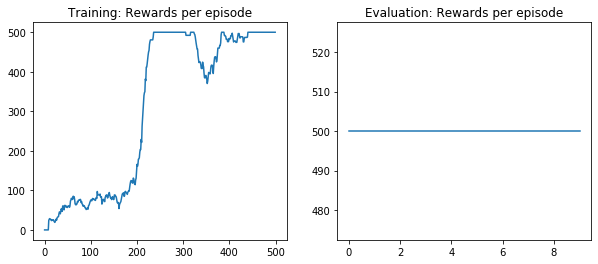

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
#TD actor-critic on CartPole-v1
agent = AC_Cartpole_Agent(alpha=0.00001, beta=0.00005)
env = gym.make('CartPole-v1')

states_size = env.observation_space.shape[0]

#episodes
total_episodes = 500
eval_episodes = total_episodes - 10

#lists to store rewards
reward_values = []
rewards = []
eva_rewards = []
avg_rewards = 0


for episode in range(1, total_episodes+1):
    
    done = False
    total_rewards = 0
    timesteps = 0
    state = env.reset()
    obs = np.reshape(state, [1, states_size])
    
    while not done:
        
        if episode >= eval_episodes:
            action = agent.pick_action(state, evaluation = True)
        else:
            action = agent.pick_action(state)
   
        next_state, reward_val, done, info = env.step(action)
        
        next_obs = np.reshape(next_state, [1, states_size])

        #custom reward to converge faster
        reward = -100*(abs(next_obs[0,2]) - abs(obs[0,2]))
        obs = next_obs

        #training
        agent.train(state, action, reward, next_state, done)
        state = next_state
        total_rewards += reward_val
        timesteps += 1

    #Each episode
    rewards.append(total_rewards)
    
    if episode >= 10:
      avg_rewards = np.sum(rewards[episode-10:]) / 10
    
    reward_values.append(avg_rewards)

    if episode % (total_episodes // 10) == 0 or episode == 1:
      print("Episode: {}, Average rewards: {}".format(episode, avg_rewards))
    
    #Evaluation
    if episode > eval_episodes:
      eva_rewards.append(total_rewards)
        

#plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
x = [episode for episode in range(total_episodes)]
x_eva = [episode for episode in range(10)]
yr = reward_values
ye = eva_rewards
  
ax1.plot(x,yr)
ax1.set_title("Training: Rewards per episode")

ax2.plot(x_eva,ye)
ax2.set_title("Evaluation: Rewards per episode")